In [6]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import cv2
import os
import matplotlib.pyplot as plt

def load_image(image_path):
    image = cv2.imread(image_path)
    return image

def load_support_set(folder_path):
    support_set = []
    # Iterate over the images in the folder
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        support_set.append(image)
    return support_set

def display_image(image):
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

def preprocess_image(image):
    # Resize the image to the desired dimensions
    resized_image = cv2.resize(image, (28, 28))

    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Normalize the pixel values to [0, 1]
    normalized_image = grayscale_image.astype("float32") / 255.0

    # Reshape the image to match the input shape expected by the Siamese network
    reshaped_image = np.reshape(normalized_image, (28, 28, 1))

    return reshaped_image

def preprocess_support_set(support_set):
    preprocessed_images = []
    for image in support_set:
        preprocessed_image = preprocess_image(image)
        preprocessed_images.append(preprocessed_image)
    return np.array(preprocessed_images)





In [2]:

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Access files in your Drive
file_path = '/content/drive/MyDrive'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Siamese network architecture
def create_siamese_network(input_shape):
    input_1 = tf.keras.Input(shape=input_shape)
    input_2 = tf.keras.Input(shape=input_shape)

    # Shared convolutional base
    conv_base = tf.keras.Sequential(
        [
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
        ]
    )

    # Process the two inputs
    processed_1 = conv_base(input_1)
    processed_2 = conv_base(input_2)

    # Calculate Euclidean distance between the processed inputs
    distance = tf.keras.backend.sqrt(tf.keras.backend.sum(tf.keras.backend.square(processed_1 - processed_2), axis=1, keepdims=True))

    # Siamese network model
    model = Model(inputs=[input_1, input_2], outputs=distance)
    return model

# Define input shape and number of classes for crop classification
input_shape = (224, 224, 3)
num_classes = 7

# Create Siamese Network for distance-based learning
siamese_model = create_siamese_network(input_shape)

# Load the VGG16 model with weights pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of the base model for crop classification
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Create the final model for crop classification
crop_classification_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the base model except for the last few layers for fine-tuning
for layer in base_model.layers[:-2]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

# Compile the model with a small learning rate for fine-tuning
crop_classification_model.compile(optimizer=Adam(learning_rate=0.00001),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

# Print model summary
crop_classification_model.summary()

# Define batch size and number of epochs
batch_size = 32
epochs = 20

# Load and preprocess your crop classification dataset using ImageDataGenerator
file_path = '/content/drive/MyDrive/Agricultural-crops/'
train_data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_data_gen.flow_from_directory(
    file_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_data_gen.flow_from_directory(
    file_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Train the model on your crop classification datasets
history = crop_classification_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)


58889256/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

1/1 [==============================] - 0s 33ms/step
Query Image:


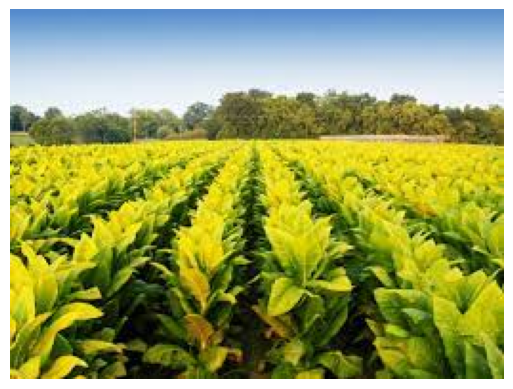

Most Similar Image:


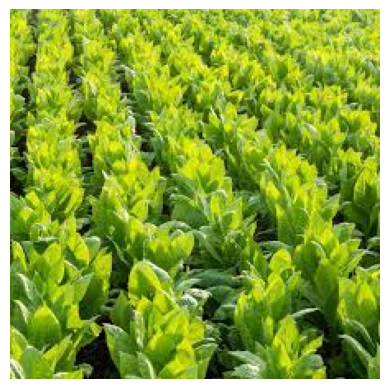

Similarity Score: 0.4286671


In [11]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def load_image(image_path):
    image = cv2.imread(image_path)
    return image

def preprocess_image(image):
    if image is None:
        raise ValueError("Image could not be loaded.")

    resized_image = cv2.resize(image, (28, 28))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    normalized_image = gray_image.astype("float32") / 255.0
    return normalized_image

def preprocess_support_set(support_set):
    preprocessed_images = []
    for image in support_set:
        preprocessed_image = preprocess_image(image)
        preprocessed_images.append(preprocessed_image)
    return np.array(preprocessed_images)

def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Load the query image and the support set
query_image_path = '/content/drive/MyDrive/test/image6.jpeg'
query_image = load_image(query_image_path)

support_set_dir = '/content/drive/MyDrive/support_set'
support_set_images = [os.path.join(support_set_dir, image_file) for image_file in os.listdir(support_set_dir)]
support_set = [load_image(image_path) for image_path in support_set_images]

# Load the pre-trained models
siamese_model = load_model('/content/drive/MyDrive/Agricultural-crops/siamese_model.h5')
crop_classification_model = load_model('/content/drive/MyDrive/Agricultural-crops/crop_classification_model_fine_tuned.h5')

# Preprocess the query image and the support set
preprocessed_query_image = preprocess_image(query_image)
preprocessed_support_set = preprocess_support_set(support_set)

# Calculate the similarity score for each image in the support set
similarity_scores = []
for support_image in preprocessed_support_set:
    siamese_predictions = siamese_model.predict([np.expand_dims(preprocessed_query_image, axis=0), np.expand_dims(support_image, axis=0)])
    similarity_score = siamese_predictions[0][0]
    similarity_scores.append(similarity_score)

# Find the index of the most similar image in the support set
most_similar_index = np.argmax(similarity_scores)

# Retrieve the most similar image from the support set
most_similar_image = support_set[most_similar_index]

# Display the query image and the most similar image from the support set
print("Query Image:")
display_image(query_image)

print("Most Similar Image:")
display_image(most_similar_image)

print("Similarity Score:", similarity_scores[most_similar_index])


In [12]:
siamese_model.save('/content/drive/MyDrive/Agricultural-crops/siamese_model.h5')


In [16]:

# Create the Siamese network
siamese_network = create_siamese_network(input_shape=(28, 28, 1))

# Compile the model
siamese_network.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = siamese_network.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels, batch_size=64, epochs=10,
                    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels))

# Evaluate the model
test_loss, test_accuracy = siamese_network.evaluate([val_pairs[:, 0], val_pairs[:, 1]], val_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



Epoch 1/10
16/16 [==============================] - 6s 98ms/step - loss: 7.3196 - accuracy: 0.5200 - val_loss: 7.6856 - val_accuracy: 0.4960
Epoch 2/10
16/16 [==============================] - 1s 85ms/step - loss: 7.3196 - accuracy: 0.5200 - val_loss: 7.6856 - val_accuracy: 0.4960
Epoch 3/10
16/16 [==============================] - 1s 83ms/step - loss: 7.3196 - accuracy: 0.5200 - val_loss: 7.6856 - val_accuracy: 0.4960
Epoch 4/10
16/16 [==============================] - 1s 85ms/step - loss: 7.3196 - accuracy: 0.5200 - val_loss: 7.6856 - val_accuracy: 0.4960
Epoch 5/10
16/16 [==============================] - 1s 84ms/step - loss: 7.3196 - accuracy: 0.5200 - val_loss: 7.6856 - val_accuracy: 0.4960
Epoch 6/10
16/16 [==============================] - 1s 83ms/step - loss: 7.3196 - accuracy: 0.5200 - val_loss: 7.6856 - val_accuracy: 0.4960
Epoch 7/10
16/16 [==============================] - 2s 106ms/step - loss: 7.3196 - accuracy: 0.5200 - val_loss: 7.6856 - val_accuracy: 0.4960
Epoch 8/10
1

In [20]:
# Assuming the Siamese network is created and trained, and the variable 'siamese_network' contains the model.

# Save the model to a file
siamese_network.save('/content/drive/MyDrive/Agricultural-crops/siamese_model.h5')

print("Model saved successfully.")


Model saved successfully.


In [21]:
siamese_network

In [2]:

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Access files in your Drive
file_path = '/content/drive/MyDrive'


Mounted at /content/drive


In [24]:
import os
import tensorflow as tf
from PIL import Image
import numpy as np

# Load the Siamese model from the saved file
siamese_model_path = '/content/drive/MyDrive/Agricultural-crops/siamese_model.h5'
siamese_model = tf.keras.models.load_model(siamese_model_path)

# Function to preprocess the query image for prediction
def preprocess_query_image(image_path, input_size):
    img = Image.open(image_path).convert('L')  # Convert to grayscale (1 channel)
    img = img.resize(input_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to preprocess the support set for prediction
def preprocess_support_set(image_paths, input_size):
    support_set = []
    for image_path in image_paths:
        img = Image.open(image_path).convert('L')  # Convert to grayscale (1 channel)
        img = img.resize(input_size)
        img_array = np.array(img) / 255.0
        support_set.append(img_array)
    return np.array(support_set)

# Load the query image
query_image_path = '/content/drive/MyDrive/test/query_image.jpg'
query_image = preprocess_query_image(query_image_path, (28, 28))

# Load and preprocess the support set
support_set_dir = '/content/drive/MyDrive/support_set'
support_set_images = [os.path.join(support_set_dir, image_file) for image_file in os.listdir(support_set_dir)]
support_set = preprocess_support_set(support_set_images, (28, 28))

# Define the predict function with tf.function decorator
@tf.function
def predict_features(images):
    return siamese_model(images)

# Compute feature representations for the query image and support set
query_features = predict_features([query_image, query_image])
support_features = predict_features([support_set, support_set])

# Calculate distances
distances = np.linalg.norm(query_features - support_features, axis=1)  # Euclidean distance

# Find the index of the most similar image
most_similar_index = np.argmin(distances)

# Load and display the most similar image from the support set
most_similar_image_path = support_set_images[most_similar_index]
most_similar_image = Image.open(most_similar_image_path)
most_similar_image.show()
# Get the crop name corresponding to the most similar image
most_similar_crop = crop_labels[most_similar_index]
print("Most Similar Crop:", most_similar_crop)


Most Similar Crop: Cucumber


In [3]:
import os
import tensorflow as tf
from PIL import Image
import numpy as np

# Load the Siamese model from the saved file
siamese_model_path = '/content/drive/MyDrive/Agricultural-crops/siamese_model.h5'
siamese_model = tf.keras.models.load_model(siamese_model_path)

# Function to preprocess the query image for prediction
def preprocess_query_image(image_path, input_size):
    img = Image.open(image_path).convert('L')  # Convert to grayscale (1 channel)
    img = img.resize(input_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to preprocess the support set for prediction
def preprocess_support_set(image_paths, input_size):
    support_set = []
    for image_path in image_paths:
        img = Image.open(image_path).convert('L')  # Convert to grayscale (1 channel)
        img = img.resize(input_size)
        img_array = np.array(img) / 255.0
        support_set.append(img_array)
    return np.array(support_set)

# Load the query image
query_image_path = '/content/drive/MyDrive/test/query_image.jpg'
query_image = preprocess_query_image(query_image_path, (28, 28))

# Load and preprocess the support set images
support_set_dir = '/content/drive/MyDrive/support_set'
support_set_images = [os.path.join(support_set_dir, image_file) for image_file in os.listdir(support_set_dir)]
support_set = preprocess_support_set(support_set_images, (28, 28))

# Compute feature representations for the query image
query_features = siamese_model.predict([query_image, query_image])

# Compute feature representations for the support set images
support_features = siamese_model.predict([support_set, support_set])

# Calculate distances
distances = np.linalg.norm(query_features - support_features, axis=1)  # Euclidean distance

# Find the index of the most similar image from the support set
most_similar_index = np.argmin(distances)

# Load and display the most similar image from the support set
most_similar_image_path = support_set_images[most_similar_index]
most_similar_image = Image.open(most_similar_image_path)
most_similar_image.show()


1/1 [==============================] - 0s 41ms/step


In [24]:
# Assuming the Siamese network is created and trained, and the variable 'siamese_network' contains the model.

# Save the model to a file
siamese_network.save('/content/drive/MyDrive/Agricultural-crops/siamese_model2.h5')

print("Model saved successfully.")


Model saved successfully.


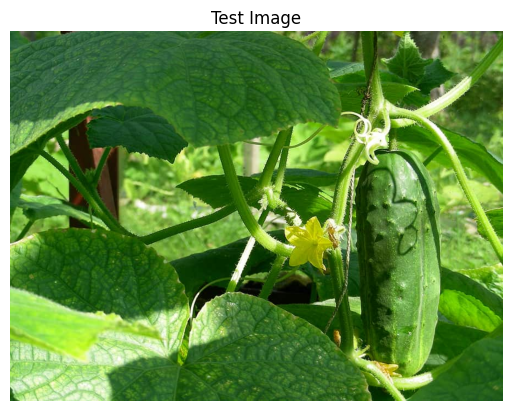

1/1 [==============================] - 1s 708ms/step
Predicted Crop Class: Cucumber


In [25]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the crop classification model from the saved file
crop_classification_model_path = '/content/drive/MyDrive/Agricultural-crops/crop_classification_model_fine_tuned.h5'
crop_classification_model = tf.keras.models.load_model(crop_classification_model_path)

# Load the siamese model from the saved file
siamese_model_path = '/content/drive/MyDrive/Agricultural-crops/siamese_model.h5'
siamese_model = tf.keras.models.load_model(siamese_model_path)

# Define input image size for crop classification
input_size = (224, 224)

# Define crop labels for displaying results
crop_classes = ['Cucumber', 'Tobacco-plant', 'jute', 'maize', 'mustard-oil', 'rice', 'wheat']

# Load an image to test
test_image_path = '/content/drive/MyDrive/test/query_image.jpg'
test_image = Image.open(test_image_path).convert('RGB')
plt.imshow(test_image)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Preprocess the test image for crop classification model
test_img_array = np.array(test_image.resize(input_size)) / 255.0
test_img_array = np.expand_dims(test_img_array, axis=0)

# Predict the crop class from the test image using the crop_classification_model
crop_class_index = np.argmax(crop_classification_model.predict(test_img_array), axis=1)[0]
predicted_crop_class = crop_classes[crop_class_index]

# Display the predicted crop class
print("Predicted Crop Class:", predicted_crop_class)

# Preprocess the test image for the siamese_model
test_img_array_preprocessed = preprocess_input(test_img_array)

# Assuming you have pairs of images for the siamese network (here using the same image as both inputs for illustration)
test_pair = [test_img_array_preprocessed, test_img_array_preprocessed]




